Most of the simulations in Molecular dynamics require Periodic boundary conditions to simulate bulk properties of a material. While many of the fast near neighbour searches are already in place, their periodic implementation in a triclinic cell is a challenge. Inorder to  implement periodic boundary condition, one has to produce images of all the particles in the neighbourhood cells. Minimum distance of the particle from the any of the image is designated as the pairwise distance between a set of particles. Ideally, to capture the images of all the particles in the vicinity of the cell, the cutoff distance should be half the cellsize, but typically the requirements of near neighbour distances are quite small compared to the box(cell) length. The box can therefore extended till a small cutoff distance and particles within the range can be duplicated. This extended box can then be supplied to the near neighbour searching algorithms which are PBC unaware. 


An implementation for PBC which is KDtree specific, is implemented in MDAnalysis. This can be used as a reference to check the performance of the above mentioned algorithm. More information about the duplication can be found [here](http://www.richardjgowers.com/2018/06/28/make_halos.html). Furthermore, as reported in this [benchmarks](http://nbviewer.jupyter.org/url/jakevdp.github.com/downloads/notebooks/memview_bench.ipynb), huge time reduction can be achieved by using cython functions as all the loops in the code are relatively constly in python.

Lets begin by comparing the performance of two non periodic tree structures 

* KDtree in BioPython  
* cKDTree in Scipy

In [67]:
import MDAnalysis as mda
from MDAnalysis.lib.distances import calc_distance, distance_array
from MDAnalysis.lib.pkdtree import PeriodicKDTree
from MDAnalysis.topology import tables
import numpy as np
from collections import defaultdict
from tqdm import tqdm_notebook
import itertools

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt

In [3]:
from Bio.KDTree import KDTree
def biopython_build(coords):
    kdtree = KDTree(dim=3)
    kdtree.set_coords(coords)
    return kdtree
def biopython_query(struct, coords, pos, cutoff):
    struct.search(pos,cutoff)
    return np.asarray(struct.get_indices())

In [4]:
from scipy import spatial
def scipy_build(coords):
    return spatial.cKDTree(coords)
def scipy_query(struct, coords, pos, cutoff):
    return np.asarray(struct.query_ball_point(pos,cutoff))

In [5]:
# Helper function for populating the points
def get_coords(box,Npoints):
    return (np.random.uniform(low=0,high=1.0,size=(Npoints,3))*box[:3]).astype(np.float32)

In [6]:
# Setup
BOX = np.array([100.,100.,100.,90.,90.,90.],dtype=np.float32)
CUTOFF = 10.
NPOINTS = 1000
coords = get_coords(BOX, NPOINTS)
query = BOX[:3]/2

# Check

Assuming all the defined points are inside the centre cell. If not, it is an extra operation which would take similar time in all the algorithms.

In [7]:
skd = scipy_build(coords)
skd_indices = scipy_query(skd, coords, query, CUTOFF)
skd_indices

array([759, 977])

In [8]:
bkd = biopython_build(coords)
bkd_indices = biopython_query(bkd, coords, query, CUTOFF)
bkd_indices

array([759, 977])

In [9]:
np.testing.assert_array_equal(np.sort(skd_indices), np.sort(bkd_indices))

# Timings

In [10]:
from tqdm import tqdm_notebook
from collections import defaultdict

In [37]:
# setup
BOX = np.array([100.,100.,100.,90.,90.,90.],dtype=np.float32)
CUTOFF = 4.
NPOINTS = np.logspace(2, 5, num=10, dtype= np.int)
query = BOX[:3]/2

In [40]:
result_build = defaultdict(list)
result_prune = defaultdict(list)

for N in tqdm_notebook(np.unique(NPOINTS)):
    coords = get_coords(BOX, N)
    #Build
    skd = scipy_build(coords)
    bkd = biopython_build(coords)
    
        
    #Timings
    res = %timeit -q -o scipy_build(coords)
    result_build['scipy'].append(res.average)
    res = %timeit -q -o biopython_build(coords)
    result_build['biopython'].append(res.average)
    
    
    #Prune
    res = %timeit -q -o scipy_query(skd, coords, query, CUTOFF)
    result_prune['scipy'].append(res.average)
    res = %timeit -q -o biopython_query(bkd, coords, query, CUTOFF)
    result_prune['biopython'].append(res.average)
    
    result_prune['N'].append(N)

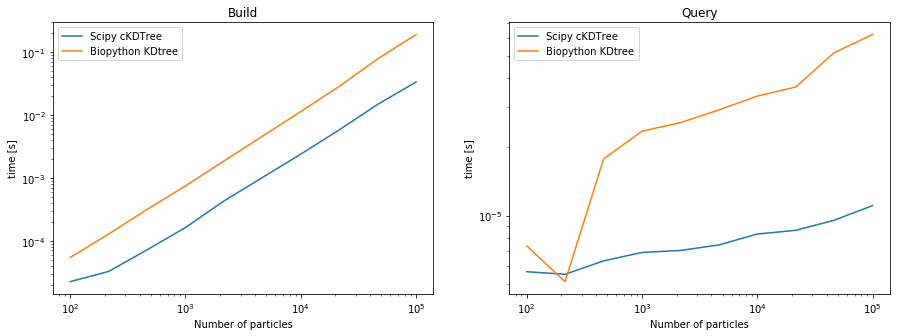

In [59]:
fig, axes = plt.subplots(ncols=2, figsize=(15,5))

ax = axes[0]
ax.plot(result_prune['N'], result_build['scipy'], label="Scipy cKDTree")
ax.plot(result_prune['N'], result_build['biopython'], label="Biopython KDtree")
ax.set(xlabel='Number of particles', ylabel='time [s]', xscale = 'log', yscale='log', title='Build')
ax.legend()

ax = axes[1]
ax.plot(result_prune['N'], result_prune['scipy'], label="Scipy cKDTree")
ax.plot(result_prune['N'], result_prune['biopython'], label="Biopython KDtree")
ax.set(xlabel='Number of particles', ylabel='time [s]', xscale = 'log', yscale='log', title='Query')
ax.legend()


Another variable is the cutoff radius. To deduce the effect of cutoff radius, lets check the variation of cutoff radius for 10000 particles.

In [60]:
# setup
BOX = np.array([100.,100.,100.,90.,90.,90.],dtype=np.float32)
CUTOFF = np.linspace(2, 15, num=13, dtype=np.float)
NPOINTS = 10000
query = BOX[:3]/2
coords = get_coords(BOX, NPOINTS)

In [61]:
result_prune = defaultdict(list)

for cut in tqdm_notebook(np.unique(CUTOFF)):
    #Build
    skd = scipy_build(coords)
    bkd = biopython_build(coords)

    #Prune
    res = %timeit -q -o scipy_query(skd, coords, query, cut)
    result_prune['scipy'].append(res.average)
    res = %timeit -q -o biopython_query(bkd, coords, query, cut)
    result_prune['biopython'].append(res.average)
    
    result_prune['cut'].append(cut)

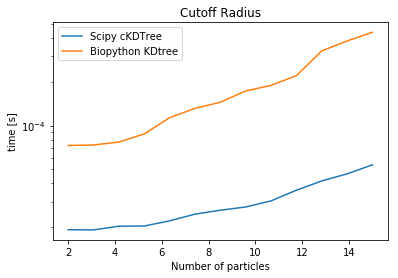

In [64]:
fig, axes = plt.subplots()

axes.plot(result_prune['cut'], result_prune['scipy'], label="Scipy cKDTree")
axes.plot(result_prune['cut'], result_prune['biopython'], label="Biopython KDtree")
axes.set(xlabel='Number of particles', ylabel='time [s]', yscale='log', title='Cutoff Radius')
axes.legend()

As it can be seen that the scipy cKDtree is faster than KDtree implementation in Biopython. It can be definitely replaced in MDAnalysis. 

The above case was only for PBC- unaware systems. As described above, the implementation of periodic boundary condition is necessary to serve the users of MDAnalysis. In the next step, duplication of particles to mimic periodic boundary conditions are shown and compared against the current implementation of periodic KDtree which uses Biopython's extension to pkdtree in pure python. 

The main idea behind the augmented coordinates (as explained [here](http://www.richardjgowers.com/2018/06/28/make_halos.html)) is to duplicate the particles by creating their images in an extended box. These duplicated particles along with the original ones can be used with any non PBC aware near neighbour searching algorithm. All the nearest neighbours can be translated back to their corresponding original coordinates in the central box. Furthermore, since it requires multiple levels of looping and repeated calculations of evaluating the images, huge time reductions are expected by using lower level instructions i.e. using cython instead of implementation in pure python. 

For this purpose, we begin by defining the cython functions to create duplicates of the particles.

In [11]:
%load_ext cython

In [12]:
%%cython

cimport cython
import cython

cimport numpy as np
import numpy as np

@cython.boundscheck(False)
@cython.wraparound(False)
def make_halo(float[:, :] coordinates, float[:] box, float r):
    """Calculate augmented coordinate set
    
    Parameters
    ----------
    coordinates : np.ndarray
      coordinates to augment
    box : np.ndarray
      size of box
    r : float
      thickness of halo region to buffer by
      
    Returns
    -------
    augmented : np.ndarray
      coordinates of the new augmented coordinates
    indices : np.ndarray
      original indices of the augmented coordinates
    """
    cdef bint lo_x, hi_x, lo_y, hi_y, lo_z, hi_z
    cdef int i, j, p, N
    cdef float shiftX[3]
    cdef float shiftY[3]
    cdef float shiftZ[3]
    cdef float coord[3]

    # room for adding triclinic support by using (3,) vectors
    shiftX[0] = box[0]
    shiftX[1] = 0.0
    shiftX[2] = 0.0
    
    shiftY[0] = 0.0
    shiftY[1] = box[1]
    shiftY[2] = 0.0
    
    shiftZ[0] = 0.0
    shiftZ[1] = 0.0
    shiftZ[2] = box[2]
    
    N = coordinates.shape[0]
    p = 0  # output counter
    
    # allocate output arrays
    # could be more conservative with this
    # or use C++ vectors + push etc
    cdef float[:, :] output = np.zeros((N, 3), dtype=np.float32)
    cdef int[:] indices = np.zeros(N, dtype=np.int32)

    for i in range(N):
        for j in range(3):
            coord[j] = coordinates[i, j]
        # detect which face regions particle i is in
        lo_x = coord[0] <= r
        hi_x = coord[0] >= box[0] - r
        lo_y = coord[1] <= r
        hi_y = coord[1] >= box[1] - r
        lo_z = coord[2] <= r
        hi_z = coord[2] >= box[2] - r
        
        if lo_x:
            # if X, face piece
            for j in range(3):
                # add to output
                output[p, j] = coord[j] + shiftX[j]
            # keep record of which index this augmented position was created from
            indices[p] = i
            p += 1
           
            if lo_y:
                # if X&Y, edge piece
                for j in range(3):
                    output[p, j] = coord[j] + shiftX[j] + shiftY[j]
                indices[p] = i
                p += 1
                
                if lo_z:
                    # if X&Y&Z, corner piece
                    for j in range(3):
                        output[p, j] = coord[j] + shiftX[j] + shiftY[j] + shiftZ[j]
                    indices[p] = i
                    p += 1
                    
                elif hi_z:
                    for j in range(3):
                        output[p, j] = coord[j] + shiftX[j] + shiftY[j] - shiftZ[j]
                    indices[p] = i
                    p += 1

            elif hi_y:
                for j in range(3):
                    output[p, j] = coord[j] + shiftX[j] - shiftY[j]
                indices[p] = i
                p += 1
                
                if lo_z:
                    for j in range(3):
                        output[p, j] = coord[j] + shiftX[j] - shiftY[j] + shiftZ[j]
                    indices[p] = i
                    p += 1
                   
                elif hi_z:
                    for j in range(3):
                        output[p, j] = coord[j] + shiftX[j] - shiftY[j] - shiftZ[j]
                    indices[p] = i
                    p += 1
                
            if lo_z:
                for j in range(3):
                    output[p, j] = coord[j] + shiftX[j] + shiftZ[j]
                indices[p] = i
                p += 1
               
            elif hi_z:
                for j in range(3):
                    output[p, j] = coord[j] + shiftX[j] - shiftZ[j]
                indices[p] = i
                p += 1
                
        elif hi_x:
            for j in range(3):
                output[p, j] = coord[j] - shiftX[j]
            indices[p] = i
            p += 1
            
            if lo_y:
                for j in range(3):
                    output[p, j] = coord[j] - shiftX[j] + shiftY[j]
                indices[p] = i
                p += 1
                
                if lo_z:
                    for j in range(3):
                        output[p, j] = coord[j] - shiftX[j] + shiftY[j] + shiftZ[j]
                    indices[p] = i
                    p += 1
                    
                elif hi_z:
                    for j in range(3):
                        output[p, j] = coord[j] - shiftX[j] + shiftY[j] - shiftZ[j]
                    indices[p] = i
                    p += 1
                

            elif hi_y:
                for j in range(3):
                    output[p, j] = coord[j] - shiftX[j] - shiftY[j]
                indices[p] = i
                p += 1
                
                if lo_z:
                    for j in range(3):
                        output[p, j] = coord[j] - shiftX[j] - shiftY[j] + shiftZ[j]
                    indices[p] = i
                    p += 1
                    
                elif hi_z:
                    for j in range(3):
                        output[p, j] = coord[j] - shiftX[j] - shiftY[j] - shiftZ[j]
                    indices[p] = i
                    p += 1
                    
            if lo_z:
                for j in range(3):
                    output[p, j] = coord[j] - shiftX[j] + shiftZ[j]
                indices[p] = i
                p += 1
                
            elif hi_z:
                for j in range(3):
                    output[p, j] = coord[j] - shiftX[j] - shiftZ[j]
                indices[p] = i
                p += 1
                
        if lo_y:
            for j in range(3):
                output[p, j] = coord[j] + shiftY[j]
            indices[p] = i
            p += 1
            
            if lo_z:
                for j in range(3):
                    output[p, j] = coord[j] + shiftY[j] + shiftZ[j]
                indices[p] = i
                p += 1
                
            elif hi_z:
                for j in range(3):
                    output[p, j] = coord[j] + shiftY[j] - shiftZ[j]
                indices[p] = i
                p += 1
                
        elif hi_y:
            for j in range(3):
                output[p, j] = coord[j] - shiftY[j]
            indices[p] = i
            p += 1
            

            if lo_z:
                for j in range(3):
                    output[p, j] = coord[j] - shiftY[j] + shiftZ[j]
                indices[p] = i
                p += 1
                
            elif hi_z:
                for j in range(3):
                    output[p, j] = coord[j] - shiftY[j] - shiftZ[j]
                indices[p] = i
                p += 1
                
        if lo_z:
            for j in range(3):
                output[p, j] = coord[j] + shiftZ[j]
            indices[p] = i
            p += 1
            
        elif hi_z:
            for j in range(3):
                output[p, j] = coord[j] - shiftZ[j]
            indices[p] = i
            p += 1
            
    return np.array(output[:p]), np.array(indices[:p])


@cython.boundscheck(False)
@cython.wraparound(False)
def undo_augment(int[:] results, int[:] translation, int nreal):
    """Translate augmented indices back to originals
    
    Note: modifies results in place!
    
    Parameters
    ----------
    results : ndarray of ints
      indices of coordinates, including "augmented" indices
    translation : ndarray of ints
      original indices of augmented coordinates
    nreal : int
      number of real coordinates, ie values in results equal or larger than this
      need to be translated to their real counterpart
      
    Returns
    -------
    results : ndarray of ints
    """
    cdef int N
    
    N = results.shape[0]
    
    for i in range(N):
        if results[i] >= nreal:
            results[i] = translation[results[i] - nreal]
            
    return results

Helper function to access the periodic KDTree as implemented in MDAnalysis, as well as the cython functions introduced above.

In [13]:
# Helper function for the cython functions described above
def augment_kdtree(coords, cutoff, box):
    aug, idx = make_halo(coords, box, cutoff)
    aug_coord = np.concatenate([coords, aug])
    kdtree = spatial.cKDTree(aug_coord)
    pairs = np.array(list(kdtree.query_pairs(cutoff)), dtype=np.int32)
    if len(pairs) > 1:
        undo_augment(pairs[:, 0], idx, len(coords))
        undo_augment(pairs[:, 1], idx, len(coords))
        pairs = np.unique(np.sort(pairs), axis=0)
    return pairs

In [14]:
# PKDtree
import MDAnalysis.lib.distances as distances
def pkdtree(coords, cutoff, box):
    pairs, dist = distances.capped_distance(coords, coords, max_cutoff=cutoff, min_cutoff=1e-7, box=box, method='pkdtree')
    if len(pairs) > 1:
        pairs = pairs[np.where(pairs[:, 0] < pairs[:, 1])[0]]
    return np.asarray(pairs)

# Check

In [300]:
# setup
BOX = np.array([100.,100.,100.,90.,90.,90.],dtype=np.float32)
CUTOFF = 4.
NPOINTS = 1000
coords = get_coords(BOX, NPOINTS)

In [301]:
pairs_pkd = pkdtree(coords, CUTOFF, BOX)
pairs_pkd.shape

(132, 2)

In [305]:
pairs_cy = augment_kdtree(coords, CUTOFF, BOX)
pairs_cy.shape

(132, 2)

It has already been established that the performance of scipy KDtree is faster that that of biopython KDtree. The next objective is to check whether the superior performance of nonperiodic KDtree can be replaced with periodic implementation of KDtree in MDAnalysis. For this purpose, the implemented use case is to identify the bonds between the atoms.

# Benchmarks

In [308]:
# Setup
BOX = np.array([100.,100.,100.,90.,90.,90.],dtype=np.float32)
CUTOFF = 4.
NPOINTS = np.logspace(2, 5, num=10, dtype=np.int)

In [309]:
result_guess = defaultdict(list)
for N in tqdm_notebook(np.unique(NPOINTS)):
    coords = get_coords(BOX, N)
    
    #Testing
    np.testing.assert_array_equal(pkdtree(coords, CUTOFF, BOX), augment_kdtree(coords, CUTOFF, BOX))
    
    #Timing
    res = %timeit -q -o pkdtree(coords, CUTOFF, BOX)
    result_guess['pkd'].append(res.average)
    
    res = %timeit -q -o augment_kdtree(coords, CUTOFF, BOX)
    result_guess['pscipy'].append(res.average)
    
    result_guess['N'].append(N)
    

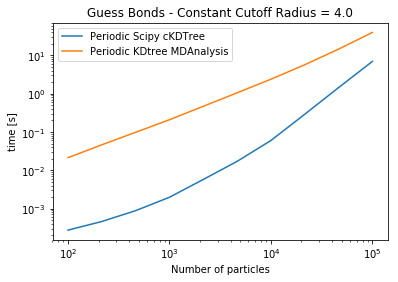

In [311]:
fig, axes = plt.subplots()

axes.plot(result_guess['N'], result_guess['pscipy'], label="Periodic Scipy cKDTree")
axes.plot(result_guess['N'], result_guess['pkd'], label="Periodic KDtree MDAnalysis")
axes.set(xlabel='Number of particles', ylabel='time [s]', xscale='log', yscale='log', title='Guess Bonds - Constant Cutoff Radius = {}'.format(CUTOFF))
axes.legend()

Since cutoff radius is another parameter and extension of coordintates depends on the cutoff radius, it is essential to assess the performance change due to change in cutoff radius. To check the variation with particle size, lets sample three particle densities i.e. number of particles as 100, 10000, 100000.

In [17]:
# setup
NPOINTS = [100, 10000, 100000]
CUTOFF = np.linspace(2, 6, num=4)
BOX = np.array([100.,100.,100.,90.,90.,90.],dtype=np.float32)

In [18]:
res_cutoff = defaultdict(list)
for N in tqdm_notebook(np.unique(NPOINTS)):
    coords = get_coords(BOX, N)
    for cut in tqdm_notebook(np.unique(CUTOFF)):
        res = %timeit -q -o pkdtree(coords, cut, BOX)
        res_cutoff[str(N)+'.pkdtree'].append(res.average)
        
        res = %timeit -q -o augment_kdtree(coords, cut, BOX)
        res_cutoff[str(N)+'.scipy'].append(res.average)
        
        res_cutoff['cut'].append(cut)

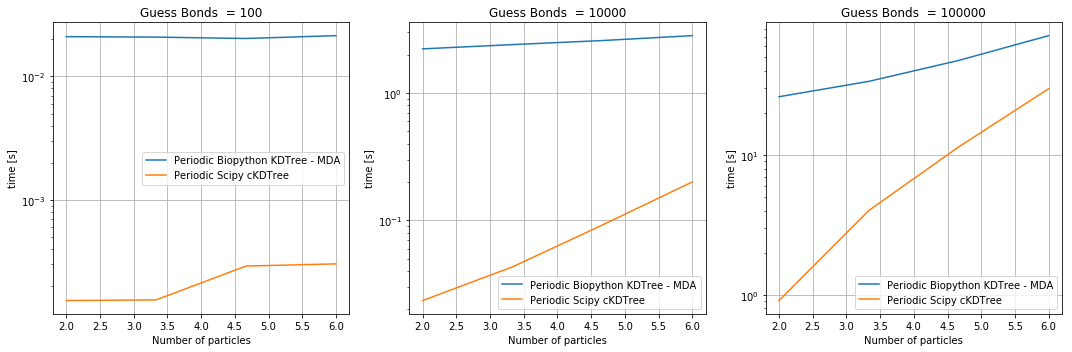

In [23]:
fig, axes = plt.subplots(ncols=3, figsize=(15, 5))

for i in range(len(NPOINTS)):
    ax = axes[i]
    ax.plot(CUTOFF, res_cutoff[str(NPOINTS[i])+'.pkdtree'], label="Periodic Biopython KDTree - MDA")
    ax.plot(CUTOFF, res_cutoff[str(NPOINTS[i])+'.scipy'], label="Periodic Scipy cKDTree")
    ax.set(xlabel='Number of particles', ylabel='time [s]', yscale='log', title='Guess Bonds  = {}'.format(NPOINTS[i]))
    ax.legend()
    ax.grid(True)
fig.tight_layout()

It can be seen that performance of scipy is faster with the cython implementation of periodic boundary conditions by approximately an order of magnitude for less number of particles and atleast 3 times faster at higher particle density.

As it is established scipy KDtree is faster than the periodic kdtree method (implemented in MDA). Lets compare the guess bonds for two real cases using PBC aware scipy KDtree, actual implementation of guess_bonds in MDA (brute force) and current periodic KDtree implementation in MDA.

In [84]:
# Lets modify the functions to deal with the actual guess bonds scenario, where every atom can have a separate radius
def mda_guessbonds(points, atomtypes=None, box=None):
    """
    Guess the bonds of particles
    Two atoms form bonds if d < f*(R1 + R2)
    """
    if atomtypes is None:
        ### Use default values
        atomtype = ['C']
        atomtypes = np.random.choice(atomtype, size = len(points))
    else:
        ##First check if every atom radius correspond to one particle
        if len(points) != len(atomtypes):
            print("Atoms and Coordinates should have equal length")
            return
        ####Every atom corresponds to a radius for its respective particle
        
    fudge_factor = 0.72
    lower_bound = 0.1
    vdwradii = tables.vdwradii.copy()
    max_vdw = max([vdwradii[t] for t in atomtypes])
    
    bonds = []
    # Define a maximum distance for every atom to search based on the radius 
    # of the atom and maximum radius of atom in the atom list. 
    
    for i,coordinate in enumerate(points):
        vdw_i = vdwradii[atomtypes[i]]
        max_d = (vdw_i + max_vdw) * fudge_factor
        dist = distance_array(points[i][None, :], points[i + 1:],box=box)[0]
        idx = np.where((dist > lower_bound) & (dist <= max_d))[0]
        for a in idx:
            j = i + 1 + a
            atom_j = points[j]
            if dist[a] < (vdwradii[atomtypes[j]] + vdw_i)*fudge_factor:
                bonds.append((i, j))
    return tuple(bonds)

In [85]:
def bio_guessbonds(points, atomtypes=None, box=None):
    """
    For periodic boundary conditions, a wrapper around Biopython._CKDTree
    is already implemented, which can be used directly presumably it is faster 
    than the KDtree implementation than BioPython KDtree.
    """
    if atomtypes is None:
        ### Use default values
        atomtype = ['C']
        atomtypes = np.random.choice(atomtype, size = len(points))
    else:
        ##First check if every atom radius correspond to one particle
        if len(points) != len(atomtypes):
            print("Atoms and Coordinates should have equal length")
            return
        
    fudge_factor = 0.72
    lower_bound = 0.1

    bonds = []
    vdwradii = tables.vdwradii.copy()
    max_vdw = max([vdwradii[t] for t in atomtypes])
    
    kdtree = PeriodicKDTree(box, bucket_size=10)
    kdtree.set_coords(points)
    
    for idx,centers in enumerate(points):
        vdw_i = vdwradii[atomtypes[idx]]
        max_d = (vdw_i + max_vdw)*fudge_factor
        kdtree.search(centers,max_d)
        indices = kdtree.get_indices()
        dist = distance_array(centers.reshape((1,3)), points[indices],box=box)[0]
        index = np.where((dist > lower_bound) & (dist <= max_d))[0]
        for j in index:
            if (indices[j] > idx) and (dist[j] < (vdwradii[atomtypes[indices[j]]] + vdw_i)*fudge_factor):
                bonds.append((idx, indices[j])) 
    return tuple(bonds)

In [86]:
def capped_guessbonds(points, atomtypes=None, box=None):
    """
    Using the capped_distances method defined in distances.py
    """
    if atomtypes is None:
        ### Use default values
        atomtype = ['C']
        atomtypes = np.random.choice(atomtype, size = len(points))
    else:
        ##First check if every atom radius correspond to one particle
        if len(points) != len(atomtypes):
            print("Atoms and Coordinates should have equal length")
            return
    
    fudge_factor = 0.72
    lower_bound = 0.1

    bonds = []
    vdwradii = tables.vdwradii.copy()
    max_vdw = max([vdwradii[t] for t in atomtypes])
    pairs, dist = distances.capped_distance(points, points, max_cutoff=2*max_vdw, min_cutoff=lower_bound, box=box, method='pkdtree')
    for idx, (i,j) in enumerate(pairs):
        if dist[idx] < (vdwradii[atomtypes[i]] + vdwradii[atomtypes[j]])*fudge_factor and i < j:
            bonds.append((i,j))
    return tuple(bonds)

In [87]:
def scipy_guessbonds(points, atomtypes=None, box=None):
    """
    Scipy ckdtree alogn with cython implementation of periodic boundary conditions
    """
    if atomtypes is None:
        ### Use default values
        atomtype = ['C']
        atomtypes = np.random.choice(atomtype, size = len(points))
    else:
        ##First check if every atom radius correspond to one particle
        if len(points) != len(atomtypes):
            print("Atoms and Coordinates should have equal length")
            return
    
    fudge_factor = 0.72
    lower_bound = 0.1

    bonds = []
    vdwradii = tables.vdwradii.copy()
    max_vdw = max([vdwradii[t] for t in atomtypes])
    pairs = augment_kdtree(points, 2.0*max_vdw, box)
    for idx, (i,j) in enumerate(pairs):
        dist = calc_distance(points[i], points[j],box=box)
        if dist < (vdwradii[atomtypes[i]] + vdwradii[atomtypes[j]])*fudge_factor and dist > lower_bound:
            bonds.append((i,j))
    return tuple(bonds)

In [73]:
#Setup
## to check a default case with a constant radius
NPOINTS = 1000
BOX = np.array([100.,100.,100.,90.,90.,90.],dtype=np.float32)
coords = get_coords(BOX, NPOINTS)

# Check

In [88]:
bonds_mda=mda_guessbonds(coords, box=BOX)

In [89]:
bonds_bp=bio_guessbonds(coords, box=BOX)

In [90]:
bonds_capped=capped_guessbonds(coords, box=BOX)

In [91]:
bonds_scipy=scipy_guessbonds(coords, box=BOX)

In [92]:
for a,b in itertools.combinations([bonds_mda, bonds_bp, bonds_capped, bonds_scipy], 2):
    np.testing.assert_array_equal(np.sort(a, axis=0), np.sort(b, axis=0))

# Initialize

In [93]:
u1,u2 = mda.Universe('small.gro'), mda.Universe('big.gro')

In [94]:
# Check the result with the function inside MDAnalysis
import MDAnalysis.topology.guessers as mda_bf
len(mda_bf.guess_bonds(u1.atoms, u1.atoms.positions, u1.dimensions))

8284

In [95]:
bonds_mda=mda_guessbonds(u1.atoms.positions,u1.atoms.types, box=u1.dimensions)

In [97]:
bonds_bp=bio_guessbonds(u1.atoms.positions,u1.atoms.types, box=u1.dimensions)

In [98]:
bonds_capped=capped_guessbonds(u1.atoms.positions,u1.atoms.types, box=u1.dimensions)

In [99]:
bonds_scipy=scipy_guessbonds(u1.atoms.positions,u1.atoms.types, box=u1.dimensions)

In [102]:
print(len(bonds_mda), len(bonds_bp), len(bonds_capped), len(bonds_scipy))

8284 8284 8284 8284


# Benchmark

For Smaller Systems

In [103]:
%timeit -q -o mda_bf.guess_bonds(u1.atoms, u1.atoms.positions, u1.dimensions)

<TimeitResult : 2.86 s ± 176 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)>

In [104]:
%timeit -q -o bio_guessbonds(u1.atoms.positions,u1.atoms.types, box=u1.dimensions)

<TimeitResult : 2.69 s ± 163 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)>

In [105]:
%timeit -q -o capped_guessbonds(u1.atoms.positions,u1.atoms.types, box=u1.dimensions)

<TimeitResult : 3.11 s ± 68.6 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)>

In [106]:
%timeit -q -o scipy_guessbonds(u1.atoms.positions,u1.atoms.types, box=u1.dimensions)

<TimeitResult : 926 ms ± 31.4 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)>

The performance is approximately 30% faster than as compared to the original implementation in MDAnalysis, even for small number of particles. Furthermore, performance of scipy + cython PBC also surpass the biopython implementation currently established in MDAnalysis.  

For Larger System

Only the best performing implementation of Periodic KDtree (Cython PBC + Scipy KDTree) is checked against the current implementation of guess_bonds in MDAnalysis

In [ ]:
%timeit -q -o -n 1 -r 1 mda_bf.guess_bonds(u2.atoms, u2.atoms.positions, u2.dimensions)

In [110]:
%timeit -q -o -n 1 -r 1 bio_guessbonds(u2.atoms.positions,u2.atoms.types, box=u2.dimensions)

<TimeitResult : 6min 5s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)>

In [108]:
%timeit -q -o -n 1 -r 1 scipy_guessbonds(u2.atoms.positions,u2.atoms.types, box=u2.dimensions)

<TimeitResult : 2min ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)>

For larger systems, the performance is improved drastically. While the guess bonds cannnot finish in even an hour, scipy version took close to 2 minutes. The current version of pure python implementation of periodic boundary condition and Biopython KDtree also performs slower than that of the scipy cKDTree.